In [1]:
import pandas as pd


comp_data = 'compiled_torque_july11.dat'

df = pd.read_csv(comp_data, sep=',')
df

,rod_id,position,angle,measurement_index,point_index,value
0,Rod3,endN3,0,0,0,-0.00112
1,Rod3,endN3,0,0,1,-0.00145
2,Rod3,endN3,0,0,2,-0.00096
3,Rod3,endN3,0,0,3,-0.00047
4,Rod3,endN3,0,0,4,-0.00014
...,...,...,...,...,...,...
14595,Rod2,endN1,180,99,27,0.01762
14596,Rod2,endN1,180,99,28,0.01926
14597,Rod2,endN1,180,99,29,0.02041
14598,Rod2,endN1,180,99,30,0.02173


In [2]:
rod_chars = 'dataTorque/rod-lenght.txt'
dfC = pd.read_csv(rod_chars)

In [3]:
# Filter out broken rods (optional)
dfC = dfC[dfC['Rod'].str.contains("Rod") & ~dfC['Rod'].str.contains("not working|broken", case=False)].copy()

# Standardize rod_id
dfC['rod_id'] = dfC['Rod'].str.extract(r'(Rod\d+)')




In [4]:
# First merge main df with rod characteristics
df_merged = pd.merge(df, dfC.drop(columns=['Rod']), on='rod_id', how='left')
df_merged.to_csv('df_merged.csv')



In [5]:
df_merged

,rod_id,position,angle,measurement_index,point_index,value,material,lenght,diammeter
0,Rod3,endN3,0,0,0,-0.00112,al,182mm,1.6mm
1,Rod3,endN3,0,0,1,-0.00145,al,182mm,1.6mm
2,Rod3,endN3,0,0,2,-0.00096,al,182mm,1.6mm
3,Rod3,endN3,0,0,3,-0.00047,al,182mm,1.6mm
4,Rod3,endN3,0,0,4,-0.00014,al,182mm,1.6mm
...,...,...,...,...,...,...,...,...,...
14595,Rod2,endN1,180,99,27,0.01762,al,182mm,1.6mm
14596,Rod2,endN1,180,99,28,0.01926,al,182mm,1.6mm
14597,Rod2,endN1,180,99,29,0.02041,al,182mm,1.6mm
14598,Rod2,endN1,180,99,30,0.02173,al,182mm,1.6mm


In [6]:
summary_df = (
    df_merged
    .groupby(['material','rod_id', 'position','angle', 'point_index'])
    .agg(
       mean_voltage=('value', 'mean'),
       std_voltage=('value', 'std')
    )
    .reset_index()
)

def map_torque(point_index, angle):
    if angle == 90:
        return point_index * 100
    elif angle in (0, 180):
        if point_index < 20:
            return point_index * 10
        else:
            return 200 + (point_index - 19) * 50
    else:
        # fallback for unrecognized angles
        return point_index

# Apply corrected torque mapping
summary_df['torque_mg'] = summary_df.apply(
    lambda row: map_torque(row['point_index'], row['angle']),
    axis=1
)


# Optionally reorder columns
summary_df = summary_df[['material','rod_id', 'position','angle', 'point_index', 'torque_mg', 'mean_voltage', 'std_voltage']]
# Strip whitespace and lowercase
summary_df['material'] = summary_df['material'].str.strip().str.lower()


summary_df

,material,rod_id,position,angle,point_index,torque_mg,mean_voltage,std_voltage
0,al,Rod2,endN1,90,0,0,-0.001441,0.000125
1,al,Rod2,endN1,90,1,100,-0.001951,0.000134
2,al,Rod2,endN1,90,2,200,-0.002171,0.000123
3,al,Rod2,endN1,90,3,300,-0.002533,0.000134
4,al,Rod2,endN1,90,4,400,-0.003007,0.000136
...,...,...,...,...,...,...,...,...
141,al,Rod3,endN3,0,27,600,0.019515,0.000121
142,al,Rod3,endN3,0,28,650,0.021329,0.000132
143,al,Rod3,endN3,0,29,700,0.023017,0.000123
144,al,Rod3,endN3,0,30,750,0.024823,0.000129


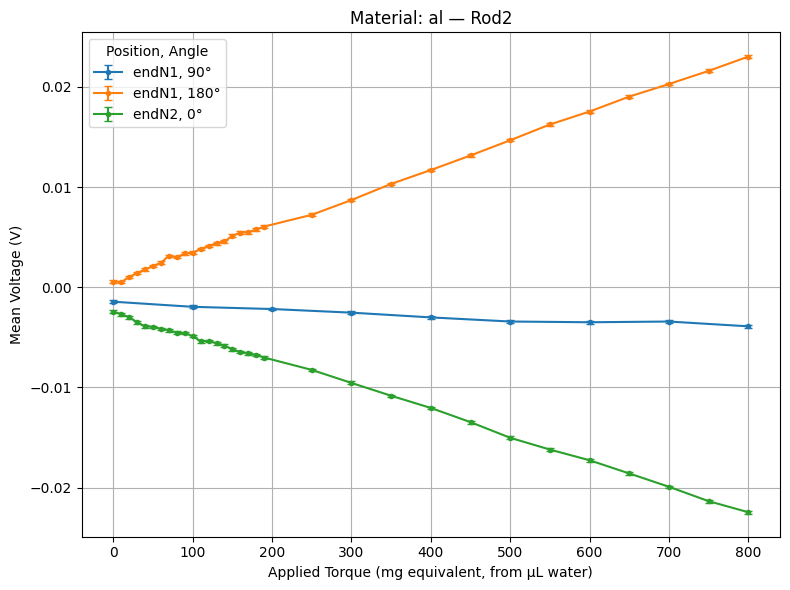

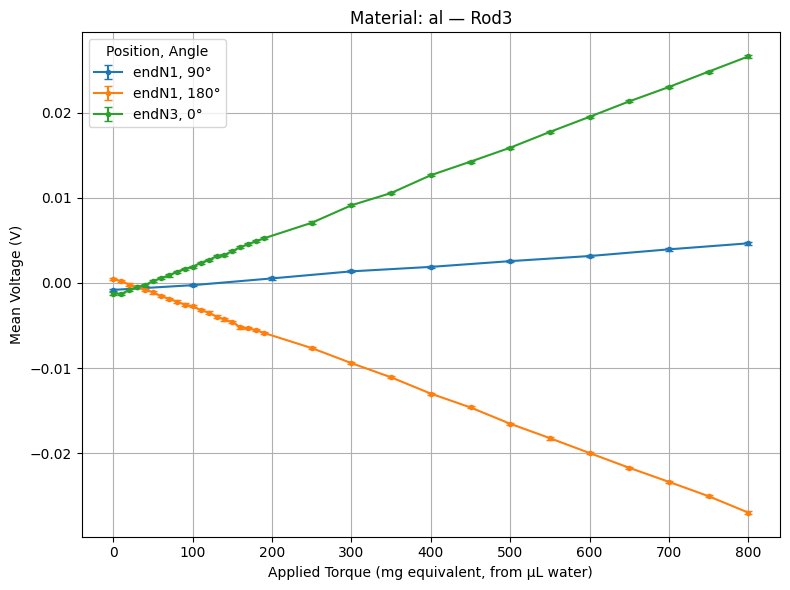

In [7]:
import matplotlib.pyplot as plt

# Unique combinations of material + rod
rod_groups = summary_df[['material', 'rod_id']].drop_duplicates()

for _, row in rod_groups.iterrows():
    mat = row['material']
    rod = row['rod_id']
    
    df_rod = summary_df[
        (summary_df['material'] == mat) & 
        (summary_df['rod_id'] == rod)
    ]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Now group by position and angle together
    for (pos, angle), df_sub in df_rod.groupby(['position', 'angle']):
        label = f"{pos}, {angle}°"
        ax.errorbar(
            df_sub['torque_mg'], 
            df_sub['mean_voltage'], 
            yerr=df_sub['std_voltage'], 
            label=label,
            capsize=3,
            marker='o',
            markersize=3,
            linestyle='-'
        )
    
    ax.set_title(f'Material: {mat} — {rod}')
    ax.set_xlabel('Applied Torque (mg equivalent, from µL water)')
    ax.set_ylabel('Mean Voltage (V)')
    ax.legend(title='Position, Angle')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
from scipy.optimize import curve_fit
import numpy as np

def linear_model(x, m, b):
    return m * x + b
    
def compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params):
    """
    Computes the effective standard deviation incorporating uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values.
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - params (tuple): Parameters of the model.

    Returns:
    - sigma_eff (array-like): Effective uncertainty combining sigma_x and sigma_y.
    """
    # Compute the derivative df/dx numerically
    delta_x = 1e-6  # Small step for numerical differentiation
    df_dx = (model_func(x_values + delta_x, *params) - model_func(x_values - delta_x, *params)) / (2 * delta_x)

    # Compute effective variance
    sigma_eff_squared = sigma_y**2 + (df_dx * sigma_x)**2
    return np.sqrt(sigma_eff_squared)

def perform_curve_fit(x_values, y_values, sigma_x, sigma_y, model_func, initial_guess):
    """
    Performs curve fitting considering uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - initial_guess (tuple): Initial guess for model parameters.

    Returns:
    - popt (array): Optimal values for the parameters.
    - pcov (2D array): The estimated covariance of popt.
    """
    # Perform initial fit without sigma_x
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_y, absolute_sigma=True, p0=initial_guess)

    # Compute effective sigma with the best-fit parameters
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, popt)

    # Refit using effective sigma
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_eff, absolute_sigma=True, p0=popt)

    return popt, pcov

def compute_chi_squared(x_values, y_values, sigma_x, sigma_y, model_func, params):
    """
    Computes chi-squared and reduced chi-squared, incorporating both y and x uncertainties.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model. (linear)
    - params (tuple): Parameters of the model. (Linear is 2)

    Returns:
    - chi_squared (float): The chi-squared value.
    - chi_squared_red (float): The reduced chi-squared value.
    """
    # Compute fitted y-values using the model function
    y_fit_values = model_func(x_values, *params)

    # Compute effective sigma
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params)

    # Compute chi-squared
    chi_squared = np.sum(((y_values - y_fit_values) ** 2) / sigma_eff**2)

    # Degrees of freedom
    dof = len(y_values) - len(params)

    # Reduced chi-squared
    chi_squared_red = chi_squared / dof

    #print("Chi-Squared:", chi_squared)
    #print("Reduced Chi-Squared:", chi_squared_red)

    return chi_squared, chi_squared_red


In [9]:
import matplotlib.colors as mcolors

# Lambda for zero uncertainty in x (torque)
zero_sigma_x = lambda x: np.full_like(x, .5)

# Function to generate visually related colors per rod
def get_rod_colors(unique_rods):
    base_colors = list(plt.cm.tab10.colors)
    color_dict = {}
    for i, rod in enumerate(unique_rods):
        base_color = np.array(base_colors[i % len(base_colors)])
        trial_colors = [
            tuple(np.clip(base_color * 0.8, 0, 1)),  # darker
            tuple(np.clip(base_color * 1.2, 0, 1)),  # lighter
            tuple(np.clip(base_color * 1.0, 0, 1)),  # original base
        ]
        color_dict[rod] = trial_colors
    return color_dict


all_fit_results = []

# Updated plotting function to include angles
def plot_material_with_fit(summary_df, material_name, model_func, initial_guess, save_path=None):
    df_mat = summary_df[summary_df['material'] == material_name]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_rods = df_mat['rod_id'].unique()
    rod_colors = get_rod_colors(unique_rods)
    
    # Group by rod, position, angle
    triple_keys = list(map(tuple, df_mat[['rod_id', 'position', 'angle']].drop_duplicates().values))
    triple_keys = sorted(triple_keys)

    for i, (rod, pos, angle) in enumerate(triple_keys):
        df_subset = df_mat[
            (df_mat['rod_id'] == rod) &
            (df_mat['position'] == pos) &
            (df_mat['angle'] == angle)
        ]

        x = df_subset['torque_mg'].values
        y = df_subset['mean_voltage'].values
        sigma_y = df_subset['std_voltage'].values
        sigma_x = zero_sigma_x(x)

        # Fit curve
        popt, pcov = perform_curve_fit(x, y, sigma_x, sigma_y, model_func, initial_guess)

        # Chi-squared
        chi2, chi2_red = compute_chi_squared(x, y, sigma_x, sigma_y, model_func, popt)

        # Assign color based on rod and position index
        pos_index = list(df_mat[df_mat['rod_id'] == rod]['position'].unique()).index(pos)
        color = rod_colors[rod][pos_index % len(rod_colors[rod])]

        # Plot data
        ax.errorbar(x, y, yerr=sigma_y, label='_nolegend_', capsize=3, marker=',', linestyle='None', markersize=4, color=color)

        # Label formatting
        trial_num = pos.replace('endN', '')
        m = popt[0]
        m_err = np.sqrt(pcov[0, 0])
        percent_err = abs(m_err / m) * 100 if m != 0 else np.nan

        # Fit curve
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = model_func(x_fit, *popt)
        ax.plot(
            x_fit, y_fit,
            linestyle='-',
            color=color,
            label=f'{rod},{trial_num} ,{angle}°: m={m:.4e} (±{percent_err:.2f}%), χ²_red={chi2_red:.2f}'
        )

        # Save fit result
        all_fit_results.append({
            'Material': material_name,
            'Rod': rod,
            'Position': pos,
            'Angle': angle,
            'Slope (m)': m,
            'Uncertainty (σ_m)': m_err,
            'Percent Error (%)': percent_err,
            'Reduced Chi²': chi2_red
        })
        
    ax.set_title(f'{material_name.capitalize()} Rods: Data and Curve Fits')
    ax.set_xlabel('Water Mass (mg) ~ Torque Load')
    ax.set_ylabel('Mean Voltage (V)')
    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    plt.tight_layout()

    if save_path:
        filename = f"{save_path}/{material_name.replace(' ', '_')}_fit.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved plot to: {filename}")
        
    plt.show()

Saved plot to: ./plots/al_fit.png


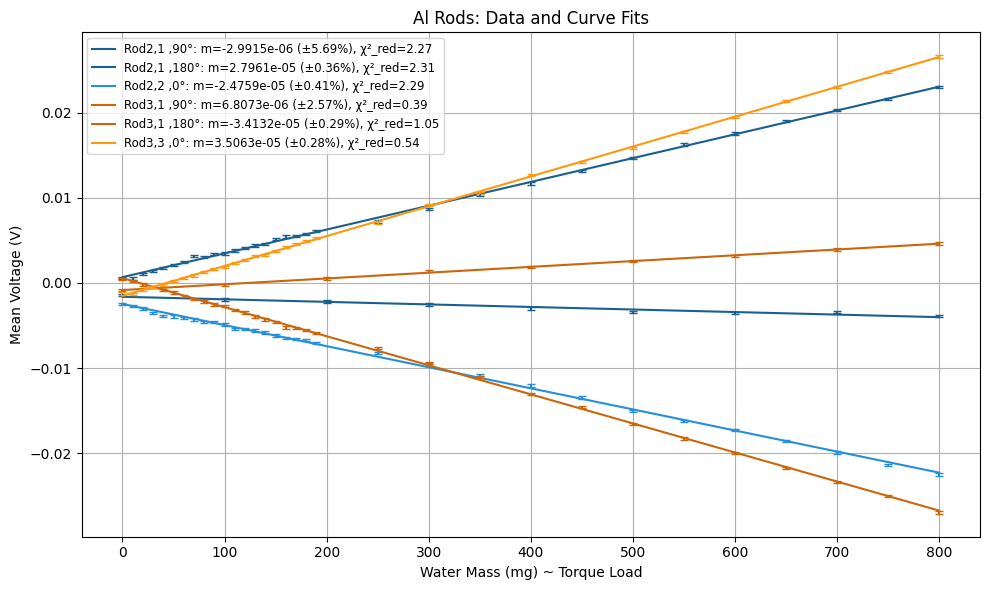

In [10]:
save_folder = "./plots"
initial_guess = (0, 0)

# For each material
plot_material_with_fit(summary_df, 'al', linear_model, initial_guess, save_path=save_folder)


# Noise and Drift Analysis for Calibration Data

## Overview

The goal is to estimate the **minimum measurable mass** these rods are capable of detecting. For that we need to quantify the **measurement noise** and **system drift** from voltage calibration data of rods under varying torque and angle configurations.

---

## Data Structure

- `df_merged`: Original dataset with repeated voltage measurements.
- Key columns:
  - `material`, `rod_id`, `position`, `angle`
  - `point_index` (torque point)
  - `measurement_index` (repeats per torque point)
  - `value` (measured voltage)

---

## Analysis Steps

### 1. Filter Angles

- Exclude all rows where `angle == 90°` to focus on 0° and 180° configurations.
- Include only the zero measurements `point_index = 0`

### 2. Noise Calculation (Random Measurement Variability)

- Group by `['material', 'rod_id', 'point_index']` to aggregate data **per rod and torque point** across positions and angles (except 90°).
- For each group, calculate:
  - **Standard deviation of voltage** (`noise_voltage_V`) across each all adquisition points (`point_index`)

---

## Usage

- The **Standard deviation of voltage** represents the smallest voltage difference reliably distinguishable from noise.
- Given the rod's **slope (V/mg)** from calibration fits, compute the **minimal detectable mass** as:

 $$
  \text{Minimal Detectable Mass (mg)} = \frac{\text{Standard deviation of voltage}}{|\text{slope}|}
$$

---

In [11]:
# Filter out angle 90°
df_filtered = df_merged[df_merged['angle'] != 90]

# Keep only the zero measurement
df_filt = df_filtered[df_filtered['point_index'] == 0]


columns = ['material', 'rod_id', 'point_index']

noise_df = (
    df_filt
    .groupby(columns)['value']
    .agg(['mean','std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'mean_voltage_V', 'std': 'noise_voltage_V'})
)
# Add the SEM column
noise_df['sem_voltage_V'] = noise_df['noise_voltage_V'] / np.sqrt(noise_df['count'])
noise_df['detectable_min_V'] = noise_df['mean_voltage_V'] + 3*noise_df['noise_voltage_V']
noise_df['detectable_max_V'] = noise_df['mean_voltage_V'] - 3*noise_df['noise_voltage_V']

for _, row in noise_df.iterrows():
    print(
        f"Rod {row['rod_id']} ({row['material']}): "
        f"Mean zero-load = {row['mean_voltage_V']:.6f} V, "
        f"Noise (std) = {row['noise_voltage_V']:.6f} V, "
        f"Detectable signal > {row['detectable_min_V']:.6f} V, < {row['detectable_max_V']:.6f} V"
    )


Rod Rod2 (al): Mean zero-load = -0.000933 V, Noise (std) = 0.001512 V, Detectable signal > 0.003603 V, < -0.005469 V
Rod Rod3 (al): Mean zero-load = -0.000382 V, Noise (std) = 0.000885 V, Detectable signal > 0.002272 V, < -0.003036 V


In [12]:
# Select relevant columns
config_metrics = noise_df[['rod_id', 'sem_voltage_V']].copy()

# Calculate total voltage margin
config_metrics['total_voltage_margin_V'] = 1 * config_metrics['sem_voltage_V']

# Print rounded output
print(config_metrics.round(8))



  rod_id  sem_voltage_V  total_voltage_margin_V
0   Rod2       0.000107                0.000107
1   Rod3       0.000063                0.000063


In [13]:
# columns: ['material', 'rod_id', 'drift_voltage_V', 'avg_voltage_overall_V', 'median_noise_voltage_V', 'total_voltage_margin_V']

# Convert to DataFrame if not already
config_metrics_df = pd.DataFrame(config_metrics)

# Convert all_fit_results to DataFrame
fits_df = pd.DataFrame(all_fit_results)

# Merge fits with margins by material and rod_id (angle ignored for margin)
merged_df = pd.merge(
    fits_df,
    config_metrics_df[['rod_id', 'total_voltage_margin_V']],
    left_on=['Rod'],
    right_on=['rod_id'],
    how='left'
)

records = []
for _, row in merged_df.iterrows():
    slope = float(row['Slope (m)'])
    rel_err = float(row['Percent Error (%)'])
    chi2 = float(row['Reduced Chi²'])
    label = f"{row['Rod']} {row['Angle']}°"
    delta_y = float(row['total_voltage_margin_V'])

    # Safety check in case margin is missing
    if np.isnan(delta_y) or delta_y == 0:
        continue

    m_min = delta_y / abs(slope)
    records.append({
        "Fit": label,
        "Slope": slope,
        "RelErr_pct": rel_err,
        "Chi2_red": chi2,
        "DeltaY": delta_y,
        "Mass_min (mg)": m_min
    })

df_results = pd.DataFrame(records)

# Formatting for output
pretty = df_results.copy()
pretty["Slope"] = pretty["Slope"].apply(lambda x: f"{x:.3e}")  # scientific notation
pretty["RelErr_pct"] = pretty["RelErr_pct"].apply(lambda x: f"{x:.2f}%")  # add % sign
pretty["Mass_min (mg)"] = pretty["Mass_min (mg)"].round(2)
pretty["Chi2_red"] = pretty["Chi2_red"].round(6)
pretty["DeltaY"] = pretty["DeltaY"].round(6)

pretty_sorted = pretty.sort_values("Mass_min (mg)").reset_index(drop=True)
print(pretty_sorted.to_string(index=False))


      Fit      Slope RelErr_pct  Chi2_red   DeltaY  Mass_min (mg)
  Rod3 0°  3.506e-05      0.28%  0.541853 0.000063           1.78
Rod3 180° -3.413e-05      0.29%  1.045841 0.000063           1.83
Rod2 180°  2.796e-05      0.36%  2.307024 0.000107           3.82
  Rod2 0° -2.476e-05      0.41%  2.285793 0.000107           4.32
 Rod3 90°  6.807e-06      2.57%  0.394554 0.000063           9.19
 Rod2 90° -2.992e-06      5.69%  2.273498 0.000107          35.74


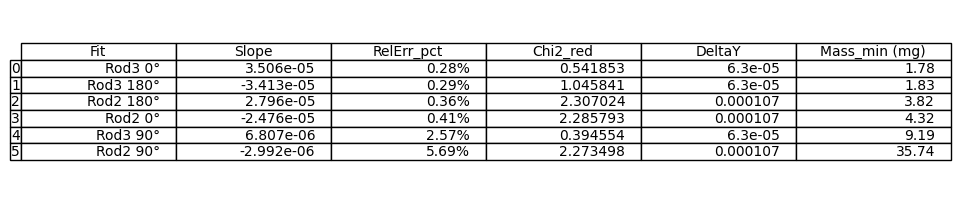

In [14]:
latex_table = pretty_sorted.to_latex(index=False, caption="Minimal Detectable Mass per Fit", label="tab:min_detect_mass")
#print(latex_table)
#from IPython.display import display, Markdown

#display(Markdown(latex_table))

from pandas.plotting import table

fig, ax = plt.subplots(figsize=(len(pretty_sorted.columns)*2, len(pretty_sorted)*0.4))
ax.axis('off')

table(ax, pretty_sorted, loc='center')

plt.savefig("table_min_detect_mass_alt.png", dpi=300)
plt.show()


In [15]:
df_rod3_0 = df_merged[(df_merged['rod_id'] == 'Rod3') & (df_merged['angle'] == 0)]
df_rod3_0

,rod_id,position,angle,measurement_index,point_index,value,material,lenght,diammeter
0,Rod3,endN3,0,0,0,-0.00112,al,182mm,1.6mm
1,Rod3,endN3,0,0,1,-0.00145,al,182mm,1.6mm
2,Rod3,endN3,0,0,2,-0.00096,al,182mm,1.6mm
3,Rod3,endN3,0,0,3,-0.00047,al,182mm,1.6mm
4,Rod3,endN3,0,0,4,-0.00014,al,182mm,1.6mm
...,...,...,...,...,...,...,...,...,...
3195,Rod3,endN3,0,99,27,0.01942,al,182mm,1.6mm
3196,Rod3,endN3,0,99,28,0.02140,al,182mm,1.6mm
3197,Rod3,endN3,0,99,29,0.02304,al,182mm,1.6mm
3198,Rod3,endN3,0,99,30,0.02501,al,182mm,1.6mm


Noise mean: -0.000657, Noise std: 0.001268


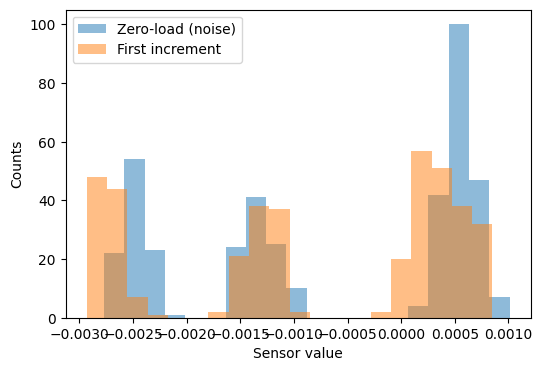

In [16]:
import pandas as pd

# Filter zero-load points
zero_load = df_filtered[df_filtered['point_index'] == 0]

# Standard deviation (noise)
noise_std = zero_load['value'].std()
noise_mean = zero_load['value'].mean()

print(f"Noise mean: {noise_mean:.6f}, Noise std: {noise_std:.6f}")

first_signal = df_filtered[df_filtered['point_index'] == 1]['value']
signal_vs_noise = first_signal - noise_mean

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(zero_load['value'], bins=20, alpha=0.5, label='Zero-load (noise)')
plt.hist(df_filtered[df_filtered['point_index'] == 1]['value'], bins=20, alpha=0.5, label='First increment')
plt.xlabel('Sensor value')
plt.ylabel('Counts')
plt.legend()
plt.show()


In [17]:
detectable_min = noise_mean + 3*noise_std
detectable_max = noise_mean - 3*noise_std
print(f"Smallest detectable signal (approx): > {detectable_min:.6f} or < {detectable_max:.6f}")


Smallest detectable signal (approx): > 0.003145 or < -0.004460


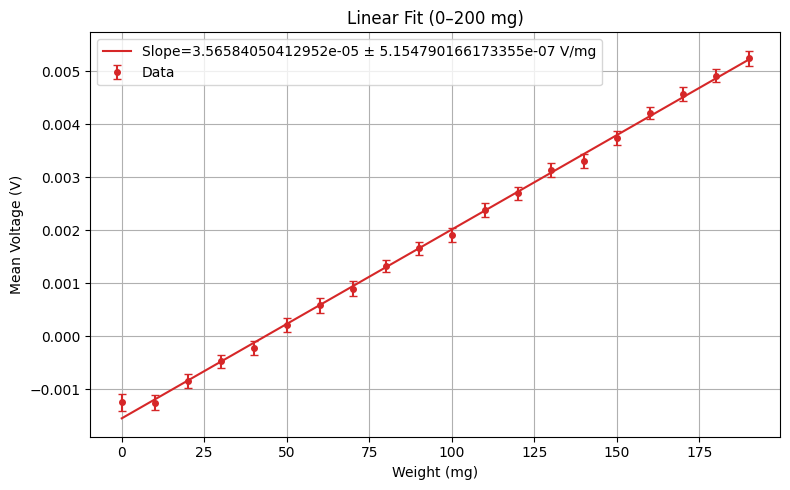

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Filter Rod3, endN3, angle=0 and torque 0–200 mg ---
df_r3 = summary_df[
    (summary_df['rod_id'] == 'Rod3') &
    (summary_df['position'] == 'endN3') &
    (summary_df['angle'] == 0) &
    (summary_df['torque_mg'].between(0, 200))
].copy()

# Extract arrays
x = df_r3['torque_mg'].values 
y = df_r3['mean_voltage'].values
sigma_y = df_r3['std_voltage'].values
sigma_x = zero_sigma_x(x)

# Linear model
linear_model = lambda x, m, b: m*x + b
initial_guess = [1, 0]

# Fit
popt, pcov = perform_curve_fit(x, y, sigma_x, sigma_y, linear_model, initial_guess)
chi2, chi2_red = compute_chi_squared(x, y, sigma_x, sigma_y, linear_model, popt)

m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

# --- Plot ---


fig, ax = plt.subplots(figsize=(8,5))

color = 'tab:red'

ax.errorbar(
    x, y, yerr=sigma_y,
    fmt='o', capsize=3, markersize=4, color=color, label='Data'
)

# Fit line
x_fit = np.linspace(x.min(), x.max(), 200)
ax.plot(x_fit, linear_model(x_fit, *popt), color=color,
        label=f'Slope={m} ± {m_err} V/mg')

ax.set_title('Linear Fit (0–200 mg)')
ax.set_xlabel('Weight (mg)')
ax.set_ylabel('Mean Voltage (V)')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig("plots/bestRodfit", dpi=300)
plt.show()


In [23]:
g = 9.80665  # m/s^2

# m from the fit in V/mg:
m_V_per_mg = m
m_err_V_per_mg = m_err

# Convert mg → N
mg_to_N = 1e-6 * g   # N per mg

# Slope in V/N
m_V_per_N = m_V_per_mg / mg_to_N
m_err_V_per_N = m_err_V_per_mg / mg_to_N

# Flip so k = N/V
k = 1.0 / m_V_per_N
k_err = m_err_V_per_N / (m_V_per_N**2)

# --- three significant figures ---
fmt = lambda val: f"{val:.3g}"

print("m [V/mg] =", fmt(m_V_per_mg), "±", fmt(m_err_V_per_mg))
print("m [V/N]  =", fmt(m_V_per_N),  "±", fmt(m_err_V_per_N))
print("k [N/V]  =", fmt(k),          "±", fmt(k_err))

m [V/mg] = 3.57e-05 ± 5.15e-07
m [V/N]  = 3.64 ± 0.0526
k [N/V]  = 0.275 ± 0.00398


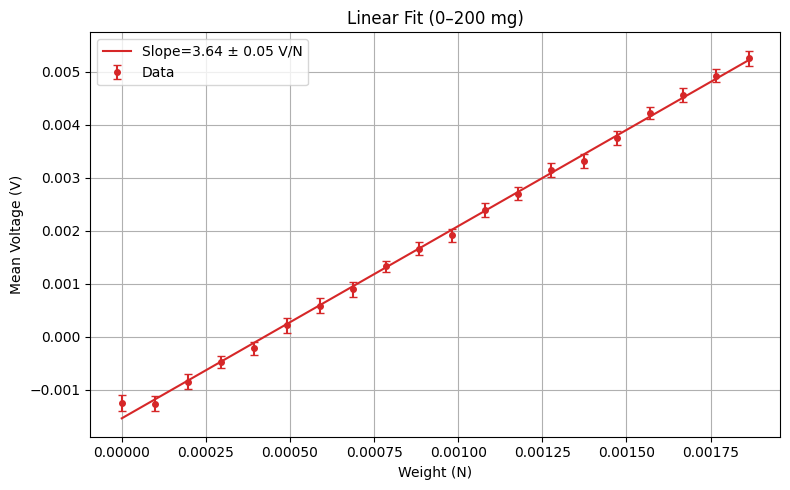

In [33]:
# Extract arrays
x = df_r3['torque_mg'].values * mg_to_N
y = df_r3['mean_voltage'].values
sigma_y = df_r3['std_voltage'].values
sigma_x = zero_sigma_x(x)

# Linear model
linear_model = lambda x, m, b: m*x + b
initial_guess = [1, 0]

# Fit
popt, pcov = perform_curve_fit(x, y, sigma_x, sigma_y, linear_model, initial_guess)
chi2, chi2_red = compute_chi_squared(x, y, sigma_x, sigma_y, linear_model, popt)

m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

fig, ax = plt.subplots(figsize=(8,5))

color = 'tab:red'

ax.errorbar(
    x, y, yerr=sigma_y,
    fmt='o', capsize=3, markersize=4, color=color, label='Data'
)

# Fit line
x_fit = np.linspace(x.min(), x.max(), 200)
ax.plot(x_fit, linear_model(x_fit, *popt), color=color,
        label=f'Slope={m_V_per_N:.2f} ± {m_err_V_per_N:.2f} V/N')

ax.set_title('Linear Fit (0–200 mg)')
ax.set_xlabel('Weight (N)')
ax.set_ylabel('Mean Voltage (V)')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig("plots/bestRodfit", dpi=300)
plt.show()
